In [127]:
import numpy as np
import pandas as pd
import pyarrow as pa
import statsmodels.formula.api as smf
from scipy.stats import boxcox, probplot, norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from QuClu import myfunctions

In [53]:
with pa.memory_map('data/Experiment3_AllFixations_short.arrow', 'r') as source:
    data = pa.ipc.open_file(source).read_all()
    
df = data.to_pandas()
df

,distance_to_spaceship,fixation_duration,Dist_to_closest_obstacles,N_visible_obstacles,input_noise,ID,level,trial,distant_fixation,cluster,disargeement
0,6.532785,0.1470,6.097491,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
1,6.075962,0.6490,2.892411,5.0,0.0,AU25IL,1.0,15,1.0,1,1.0
2,8.698109,0.5380,3.681632,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
3,6.840493,0.2160,5.004505,5.0,0.0,AU25IL,1.0,15,1.0,1,1.0
4,6.132214,0.3785,4.208327,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
27408,2.140648,0.0455,5.550318,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27409,1.782098,0.0445,5.788002,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27410,1.654277,0.0290,6.121837,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27411,1.579990,0.0030,6.335640,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0


In [54]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement'],
      dtype='object')

# Principal Component Analysis (PCA)

In [102]:
# features of interest
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]

# seperating features
x = df.loc[:, features].values

# define target
y = df.loc[:,['distant_fixation']].values

# standardize features
x = StandardScaler().fit_transform(x)

In [103]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['distance_to_spaceship', 'fixation_duration', 'Dist_to_closest_obstacles'])

In [104]:
finalDf = pd.concat([principalDf, df[['distant_fixation']]], axis = 1)

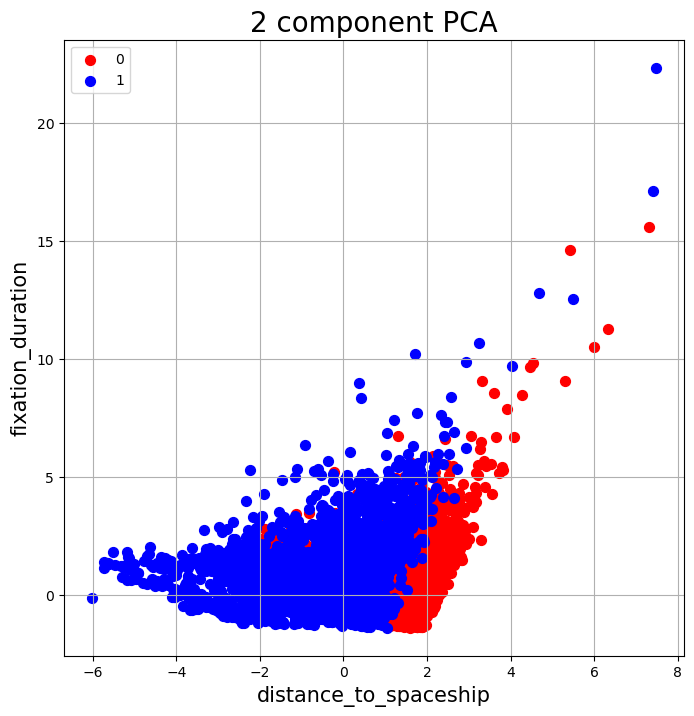

In [105]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('distance_to_spaceship', fontsize = 15)
ax.set_ylabel('fixation_duration', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['distant_fixation'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'distance_to_spaceship']
               , finalDf.loc[indicesToKeep, 'fixation_duration']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [106]:
pca.explained_variance_ratio_

array([0.39923173, 0.3317225 , 0.26904577])

# Quantile-Based Clustering

### Variable-wise theta_j and Scaled variables through lambda_j

Here, we will assess the 'elbow', as well as the silhouette score

In [67]:
dir(clu.myfunctions)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alg_CS',
 'alg_CU',
 'alg_VS',
 'alg_VU',
 'fun_CS',
 'fun_CU',
 'fun_VS',
 'fun_VU',
 'math',
 'minimize',
 'np',
 'pd']

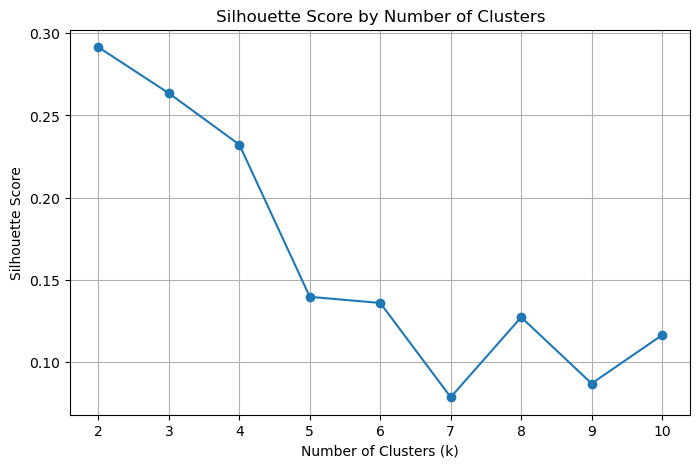

Optimal number of clusters: 2


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

# normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# silhouette score
silhouette_scores = []
K_range = range(2, 11)  # 2-10 clusters

for k in K_range:
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #labels = kmeans.fit_predict(X_scaled)
    cluster = myfunctions.alg_VS(X, k=k, B=50)
    labels = cluster['cl']
    
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# plotting
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")


In [72]:
# assinging Ncluster to data points and save
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

cluster = myfunctions.alg_VS(X, k=2, B=50)
labels = cluster['cl']

df['N_qclu'] = labels

In [ ]:
#df.to_csv('data/Experiment3_AllFixations_clustered.csv', index=False)

# Clustered Data Analysis 

In [94]:
# trial-level info (one row per ID/trial)
trial_info = (
    df[['ID', 'trial', 'level', 'input_noise']]
    .drop_duplicates()
)

# counting fixations per cluster per trial
fixation_counts = (
    df.groupby(['ID', 'trial', 'N_qclu'])
      .size()
      .reset_index(name='n_fixations')
)

# pivot
fixation_counts_pivot = fixation_counts.pivot(
    index=['ID', 'trial'],
    columns='N_qclu',
    values='n_fixations'
)


fixation_counts_pivot.columns = [f'n_fixations_cluster_{col}' for col in fixation_counts_pivot.columns]
fixation_counts_pivot = fixation_counts_pivot.reset_index()

# merge with trial-level info
merged = pd.merge(trial_info, fixation_counts_pivot, on=['ID', 'trial'])

merged = merged.fillna(0).astype({'n_fixations_cluster_0': 'int', 'n_fixations_cluster_1': 'int'})
print(merged.head())


       ID trial  level  input_noise  n_fixations_cluster_0  \
0  AU25IL    15    1.0          0.0                     23   
1  AU25IL    31    1.0          0.5                     41   
2  AU25IL    44    1.0          1.0                     76   
3  AU25IL    34    1.0          1.5                     51   
4  AU25IL    27    1.0          2.0                      6   

   n_fixations_cluster_1  
0                     12  
1                     21  
2                     23  
3                     28  
4                      4  


### Visual inspection

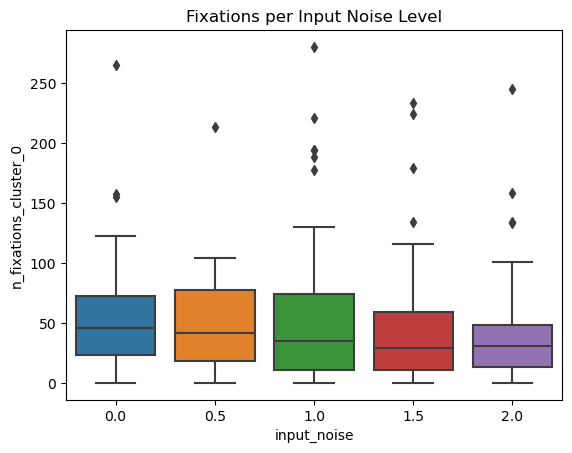

In [95]:
# visual inspection
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_0')
plt.title("Fixations per Input Noise Level")
plt.show()

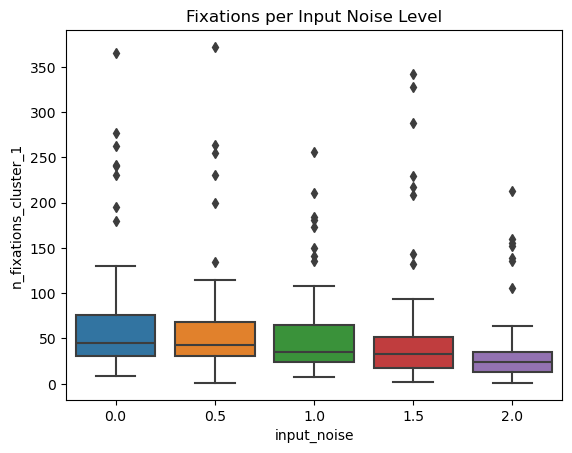

In [96]:
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_1')
plt.title("Fixations per Input Noise Level")
plt.show()

## Linear mixed effects modeling

### N fixations

In [98]:
model = smf.mixedlm(
    "n_fixations_cluster_0 ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_0
No. Observations: 254     Method:             ML                   
No. Groups:       6       Scale:              1517.4541            
Min. group size:  35      Log-Likelihood:     -1300.9445           
Max. group size:  48      Converged:          Yes                  
Mean group size:  42.3                                             
---------------------------------------------------------------------
               Coef.     Std.Err.     z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept       58.830     14.167    4.153   0.000    31.064   86.596
input_noise     -8.686      3.403   -2.553   0.011   -15.355   -2.017
Group Var     1076.402     16.724                                    
===================================================================

"""

In [101]:
model = smf.mixedlm(
    "n_fixations_cluster_1 ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_1
No. Observations: 254     Method:             ML                   
No. Groups:       6       Scale:              2813.5087            
Min. group size:  35      Log-Likelihood:     -1379.3744           
Max. group size:  48      Converged:          Yes                  
Mean group size:  42.3                                             
--------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Intercept          84.202    19.350   4.351  0.000   46.276  122.128
input_noise       -20.360     4.633  -4.394  0.000  -29.441  -11.279
Group Var        2009.746    22.886                                 
===================================================================

"""

## Analyze fixation metrics

In [107]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement',
       'N_qclu'],
      dtype='object')

In [110]:
type_0 = df[df.N_qclu == 0]
type_1 = df[df.N_qclu == 1]

### Distance to Spaceship

In [148]:
_, lmbda = boxcox(type_0.distance_to_spaceship)
lmbda

0.5391497519166921

In [149]:
type_0['distance_to_spaceship_t'] = np.sqrt(type_0.distance_to_spaceship)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/1701825223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['distance_to_spaceship_t'] = np.sqrt(type_0.distance_to_spaceship)


In [150]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 12499   Method:             ML                     
No. Groups:       6       Scale:              0.2102                 
Min. group size:  196     Log-Likelihood:     -8006.3926             
Max. group size:  4600    Converged:          Yes                    
Mean group size:  2083.2                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       1.560       0.086    18.193    0.000     1.392     1.728
input_noise    -0.022       0.006    -3.824    0.000    -0.033    -0.011
Group Var       0.044       0.056                                       
=====================================================================

"""

In [151]:
_, lmbda = boxcox(type_1.distance_to_spaceship)
lmbda

-0.8466081893916712

In [152]:
type_1['distance_to_spaceship_t'] = 1/type_1.distance_to_spaceship

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/1722555321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['distance_to_spaceship_t'] = 1/type_1.distance_to_spaceship


In [153]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 14914   Method:             ML                     
No. Groups:       6       Scale:              0.0009                 
Min. group size:  900     Log-Likelihood:     31062.9812             
Max. group size:  5808    Converged:          Yes                    
Mean group size:  2485.7                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       0.131       0.003    42.863    0.000     0.125     0.137
input_noise    -0.000       0.000    -0.652    0.515    -0.001     0.000
Group Var       0.000       0.001                                       
=====================================================================

"""

### Fixation duration

In [154]:
_, lmbda = boxcox(type_0.fixation_duration)
lmbda

0.09681068389376903

In [155]:
type_0['fixation_duration_t'] = np.log(type_0.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/331492430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['fixation_duration_t'] = np.log(type_0.fixation_duration)


In [156]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 12499   Method:             ML                 
No. Groups:       6       Scale:              1.9890             
Min. group size:  196     Log-Likelihood:     -22054.8398        
Max. group size:  4600    Converged:          Yes                
Mean group size:  2083.2                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.070      0.604   -3.425   0.001   -3.255   -0.885
input_noise    -0.096      0.018   -5.380   0.000   -0.130   -0.061
Group Var       2.187      0.889                                   
=================================================================

"""

In [157]:
_, lmbda = boxcox(type_1.fixation_duration)
lmbda

-0.01761581694031869

In [159]:
type_1['fixation_duration_t'] = np.log(type_1.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/3574830597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['fixation_duration_t'] = np.log(type_1.fixation_duration)


In [160]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 14914   Method:             ML                 
No. Groups:       6       Scale:              1.9619             
Min. group size:  900     Log-Likelihood:     -26210.1172        
Max. group size:  5808    Converged:          Yes                
Mean group size:  2485.7                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.448      0.583   -4.197   0.000   -3.592   -1.305
input_noise     0.039      0.016    2.420   0.016    0.007    0.071
Group Var       2.039      0.839                                   
=================================================================

"""

### Distance to closest obstacle

In [161]:
_, lmbda = boxcox(type_0.Dist_to_closest_obstacles)
lmbda

0.15992578857775053

In [162]:
type_0['Dist_to_closest_obstacles_t'] = np.log(type_0.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/642020871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['Dist_to_closest_obstacles_t'] = np.log(type_0.Dist_to_closest_obstacles)


In [163]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 12499   Method:             ML                         
No. Groups:       6       Scale:              0.3127                     
Min. group size:  196     Log-Likelihood:     -10481.2819                
Max. group size:  4600    Converged:          Yes                        
Mean group size:  2083.2                                                 
----------------------------------------------------------------------------
                   Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept           1.034       0.042    24.626    0.000     0.952     1.117
input_noise        -0.002       0.007    -0.296    0.767    -0.016     0.012
Group Var           0.010       0.011                                       
=========================================================================

"""

In [164]:
_, lmbda = boxcox(type_1.Dist_to_closest_obstacles)
lmbda

0.24648378437853496

In [165]:
type_1['Dist_to_closest_obstacles_t'] = np.log(type_1.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_6863/2089663632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['Dist_to_closest_obstacles_t'] = np.log(type_1.Dist_to_closest_obstacles)


In [166]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 14914   Method:             ML                         
No. Groups:       6       Scale:              0.2058                     
Min. group size:  900     Log-Likelihood:     -9386.2860                 
Max. group size:  5808    Converged:          Yes                        
Mean group size:  2485.7                                                 
-----------------------------------------------------------------------------
                Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------
Intercept       1.323        0.028     46.427     0.000      1.267      1.378
input_noise     0.035        0.005      6.612     0.000      0.024      0.045
Group Var       0.005        0.006                                           
=========================================================================

"""